# Modeling And Simulating of Dynamical Systems: Biped Walker

## Rewrite everything in casadi library: Do not use nor sympy nor numpy
### Import libraries

In [49]:
import sympy as sp
import numpy as np
from sympy.physics.mechanics import *
from numpy import sin, cos, pi
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp, solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from sympy import atan, symbols, Matrix, Eq, solve
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                     Particle, Point)
import sympy.physics.mechanics.system as system
from sympy.physics.vector import init_vprinting
import math
import casadi as ca
from casadi import *
from casadi.tools import *

# Bestekoak be asko redundante ba badaeszpada
# imports needed for the code (run this block)
import numpy as np
import matplotlib
from numpy import sin, cos, pi
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp
from scipy.interpolate import interp1d
from scipy.linalg import inv, solve_continuous_are, norm
from matplotlib import pyplot as plt
import matplotlib.pyplot as pltpiip
from matplotlib import animation
from matplotlib.patches import Rectangle
import sympy as sp
from sympy.physics.mechanics import *
from numpy.linalg import inv
from scipy.integrate import odeint, solve_bvp
from scipy.interpolate import interp1d 
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import matplotlib
from sympy import atan, symbols, Matrix
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                     Particle, Point)
import sympy.physics.mechanics.system as system
from sympy.physics.vector import init_vprinting
# matplotlib qt
# from animate_pendulum import animate_pendulum
# from animate_walker import animate_walker
def to_2d(x): return x.reshape(-1, 1)
def to_1d(x): return x[:, 0]

### Angle + Input definition
- Calculus of the angles: q are the relative angles and theta, the absolute ones.
- Input: each part of the body is applied an independent torque, simulating a motor.


In [50]:
# Generate q and input matrix (u) in function of time
# Declare symbolic variables q1, q2, q3, q4, q5, dq1, dq2, dq3, dq4, dq5
q = ca.MX.sym('q', 5, 1)
dq = ca.MX.sym('dq', 5, 1)
u = ca.MX.sym('u', 5, 1)

# Calculate the angle of each part of the body in the absolute frame
def abs_ang_rad_ca(q):
    return ca.horzcat(
        -q[4] - q[0] + pi,
        -q[4] - q[1] ,
        -q[4] - q[0] + q[2] + pi,
        -q[4] - q[1] + q[3] ,
        -q[4],
    )

# Calculate the angle of each part of the body in the absolute frame
def abs_ang_rad_np(q):
    q1, q2, q3, q4, q5 = q
    return np.hstack([
        -q5 - q1 + pi,
        -q5 - q2 ,
        -q5 - q1 + q3+ pi,
        -q5 - q2 + q4 ,
        -q5,
    ])

## Kinematics
### Position calculation
First the relative position of each part of the body is calculated and afterwards the absolute position is calculated by defining a chain of the body parts. All calculations are done in symbolic expressions.

In [51]:
def rel_pos_np(q, ratio):

    ## Declare lengths in m
    l1 = 0.8*ratio 
    l2 = 0.8*ratio
    l3 = 0.8 - l1
    l4 = 0.8 - l2
    l5 = 0.625
    length = [l1, l2, l3, l4, l5]

    ## Declare distance to gravity center in m
    l_r1 = (0.163/0.4)*l1
    l_r2 = (0.163/0.4)*l2
    l_r3 = (0.128/0.4)*l3
    l_r4 = (0.128/0.4)*l4
    l_r5 = 0.2
    l_r = [l_r1, l_r2, l_r3, l_r4, l_r5]

    # Calculate the absolute angles of each part of the body and print to verify
    theta = abs_ang_rad_np(q)
    
    # Initialize the matrices
    r_x = sp.zeros(5,1)
    r_y = sp.zeros(5,1)
    joint_x = sp.zeros(5,1)
    joint_y = sp.zeros(5,1)
    # Loop to calculate each relative position
    for i in range(5):
        # Relative position of gravity centres
        r_x[i] = (length[i] - l_r[i]) * sp.sin(theta[i])
        r_y[i] = (length[i] - l_r[i]) * sp.cos(theta[i])

        #Relative position of joints
        joint_x[i] = length[i] * sp.sin(theta[i])
        joint_y[i] = length[i] * sp.cos(theta[i])
    
    # Create the matrices for r and joints
    r_x = np.hstack(r_x)
    r_y = np.hstack(r_y)
    r = np.vstack([[r_x], [r_y]])
    joint_x = np.hstack(joint_x)
    joint_y = np.hstack(joint_y)
    joint = np.vstack([[joint_x], [joint_y]])

    # Return matrices for positions of gravity centres and joints
    return r, joint


#Calculate absolute positions of each element of the body
def abs_pos_np(q, ratio):
    # Call to relative position function
    r, joint = rel_pos_np(q, ratio)

    # Absolute position of Hip
    r [:, 0] = r[:, 0] + joint[:, 2]
    joint [:, 0] = joint[:, 0] + joint[:, 2]

    # Absolute position of Head
    r [:, 4] = r[:, 4] + joint[:, 0]
    joint [:, 4] = joint[:, 4] + joint[:, 0]

    # Absolute position of Knee 2
    r [:, 1] = r[:, 1] + joint[:, 0]
    joint [:, 1] = joint[:, 1] + joint[:, 0]

    # Absolute position of Foot 2
    r [:, 3] = r[:, 3] + joint[:, 1]
    joint [:, 3] = joint[:, 3] + joint[:, 1]

    return r, joint

In [52]:
def rel_pos_ca(angles):

    ## Declare lengths in m
    l1 = 0.4
    l2 = 0.4
    l3 = 0.4
    l4 = 0.4
    l5 = 0.625

    length = [l1, l2, l3, l4, l5]

    ## Declare distance to gravity center in m
    l_r1 = 0.163
    l_r2 = 0.163
    l_r3 = 0.128
    l_r4 = 0.128
    l_r5 = 0.2

    l_r = [l_r1, l_r2, l_r3, l_r4, l_r5]

    # Calculate the absolute angles of each part of the body and print to verify
    theta = abs_ang_rad_ca(angles)

    r_x = 0
    r_y = 0
    joint_x = 0
    joint_y = 0

    # Loop to calculate each relative position
    for i in range(5):
        # Relative position of gravity centres
        r_x_new = (length[i] - l_r[i]) * ca.sin(theta[i])
        r_y_new = (length[i] - l_r[i]) * ca.cos(theta[i])

        #Relative position of joints
        joint_x_new = length[i] * ca.sin(theta[i])
        joint_y_new = length[i] * ca.cos(theta[i])
        
        r_x = ca.horzcat(r_x, r_x_new)
        r_y = ca.horzcat(r_y, r_y_new)
        joint_x = ca.horzcat(joint_x, joint_x_new)
        joint_y = ca.horzcat(joint_y, joint_y_new)
    
    r = [r_x[1:], r_y[1:]]
    joint = [joint_x[1:], joint_y[1:]]

    # Return matrices for positions of gravity centres and joints
    return r, joint


#Calculate absolute positions of each element of the body
def abs_pos_ca(angles):
    r, joint = rel_pos_ca(angles)

    r_x = r[0]
    r_y = r[1]
    joint_x = joint[0]
    joint_y = joint[1]

    # Absolute position of Knee 1
    r_x_2 = r_x[2]
    r_y_2 = r_y[2]
    joint_x_2 = joint_x[2]
    joint_y_2 = joint_y[2]


    # Absolute position of Hip
    r_x_0 = r_x[0] + joint_x[2]
    r_y_0 = r_y[0] + joint_y[2]
    joint_x_0 = joint_x[0] + joint_x[2]
    joint_y_0 = joint_y[0] + joint_y[2]

    # Absolute position of Head
    r_x_4 = r_x[4] + joint_x_0
    r_y_4 = r_y[4] + joint_y_0
    joint_x_4 = joint_x[4] + joint_x_0
    joint_y_4 = joint_y[4] + joint_y_0

    # Absolute position of Knee 2
    r_x_1 = r_x[1] + joint_x_0
    r_y_1 = r_y[1] + joint_y_0
    joint_x_1 = joint_x[1] + joint_x_0
    joint_y_1 = joint_y[1] + joint_y_0

    # Absolute position of Foot 2
    r_x_3 = r_x[3] + joint_x_1
    r_y_3 = r_y[3] + joint_y_1
    joint_x_3 = joint_x[3] + joint_x_1
    joint_y_3 = joint_y[3] + joint_y_1

    r_x = ca.horzcat(r_x_0, r_x_1, r_x_2, r_x_3, r_x_4)
    r_y = ca.horzcat(r_y_0, r_y_1, r_y_2, r_y_3, r_y_4)
    r = [r_x, r_y]

    joint_x = ca.horzcat(joint_x_0, joint_x_1, joint_x_2, joint_x_3, joint_x_4)
    joint_y = ca.horzcat(joint_y_0, joint_y_1, joint_y_2, joint_y_3, joint_y_4)
    joint = [joint_x, joint_y]


    return r, joint

r, joint = abs_pos_ca(q)

print("Absolute position of gravity centres:\n" 
       f"{r} \n\n" 
       "Absolute position of joints:\n"
       f"{joint} \n\n")

Absolute position of gravity centres:
[MX(@1=(3.14159+((-q[4])-q[0])), @2=(3.14159+(((-q[4])-q[0])+q[2])), @3=(0.4*sin(@2)), @4=((-q[4])-q[1]), @5=((0.4*sin(@1))+@3), horzcat(((0.237*sin(@1))+@3), ((0.237*sin(@4))+@5), (0.272*sin(@2)), ((0.272*sin((((-q[4])-q[1])+q[3])))+((0.4*sin(@4))+@5)), ((0.425*sin((-q[4])))+@5))), MX(@1=(3.14159+((-q[4])-q[0])), @2=(3.14159+(((-q[4])-q[0])+q[2])), @3=(0.4*cos(@2)), @4=((-q[4])-q[1]), @5=((0.4*cos(@1))+@3), horzcat(((0.237*cos(@1))+@3), ((0.237*cos(@4))+@5), (0.272*cos(@2)), ((0.272*cos((((-q[4])-q[1])+q[3])))+((0.4*cos(@4))+@5)), ((0.425*cos(q[4]))+@5)))] 

Absolute position of joints:
[MX(@1=(0.4*sin((3.14159+(((-q[4])-q[0])+q[2])))), @2=((0.4*sin((3.14159+((-q[4])-q[0]))))+@1), @3=((0.4*sin(((-q[4])-q[1])))+@2), horzcat(@2, @3, @1, ((0.4*sin((((-q[4])-q[1])+q[3])))+@3), ((0.625*sin((-q[4])))+@2))), MX(@1=(0.4*cos((3.14159+(((-q[4])-q[0])+q[2])))), @2=((0.4*cos((3.14159+((-q[4])-q[0]))))+@1), @3=((0.4*cos(((-q[4])-q[1])))+@2), horzcat(@2, @3, @1

### Function to calculate numerically the position of the body

In [53]:
# Calculus of simulated instance position
def sim_pos_ca(q_simulated):

    # Simulate numerically the position of each joint
    r_sim, joint_sim = abs_pos_ca(q_simulated[:,:])

    # Order joints to follow body structure
    joint_x_sym = joint_sim[0]
    joint_y_sym = joint_sim[1]
    pos_x_new = [0, joint_x_sym[2], joint_x_sym[0], joint_x_sym[4], joint_x_sym[0], joint_x_sym[1], joint_x_sym[3]]
    pos_y_new = [0, joint_y_sym[2], joint_y_sym[0], joint_y_sym[4], joint_y_sym[0], joint_y_sym[1], joint_y_sym[3]]

    pos_x = pos_x_new
    pos_y = pos_y_new
    return pos_x, pos_y

In [54]:
# Calculus of simulated instance position
def sim_pos_np(q_simulated, ratio):

    # Simulate numerically the position of each joint
    r_sim, joint_sim = abs_pos_np(q_simulated, ratio)

    # Order joints to follow body structure
    joint_x_sym = joint_sim[0]
    joint_y_sym = joint_sim[1]
    pos_x = [0, joint_x_sym[2], joint_x_sym[0], joint_x_sym[4], joint_x_sym[0], joint_x_sym[1], joint_x_sym[3]]
    pos_y = [0, joint_y_sym[2], joint_y_sym[0], joint_y_sym[4], joint_y_sym[0], joint_y_sym[1], joint_y_sym[3]]

    return pos_x, pos_y

### Plotting function of the body

In [55]:
# PLOT
def plot_pos(pos_y, pos_x):
    plt.plot(pos_x, pos_y, marker='o', linestyle='--', color='b')  
    plt.title('Joint Plot')
    plt.ylabel('Y-axis')
    plt.xlabel('X-axis')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

## Dynamics
### Mass matrix

In [56]:
# Mass matrix
def M(q, m_f, m_t, l_f, l_t):

    #Define each element of the C
    M11 = (-1.4343*(l_f**2)*m_f) - ((l_f**2)*m_t) - (20*(l_f**2)) - (3.185 * l_f * m_f * ca.cos(q[2])) - (2 * l_f * m_t * ca.cos(q[2])) - (40 * l_t * m_t *  ca.cos(q[2])) - (2 * (l_t**2)*m_f) - (1.545 * (l_t**2) * m_t) - (20 * (l_t**2))
    M12 = 0.5925 * l_f * m_f * (0) * l_f * ca.sin(q[0] - q[1]) + (0 * l_t * ca.sin(-q[0]+q[1]+q[2])) - m_t * ((l_f * ca.sin(q[1] - q[3] + q[4]))*(l_f * ca.sin(q[0] + q[4] - pi) + l_t * ca.sin(q[0] - q[2] + q[4] - pi)) + (l_f * ca.cos(q[1] + q[4]) + 0.68 * l_t * ca.cos(q[1] - q[3] + q[4]))*(l_f * ca.cos(q[0] + q[4] - pi) + l_t * ca.cos(q[0] - q[2] + q[4] - pi)))
    M13 = l_t * (1.5925 * l_f * m_f * ca.cos(q[2]) + l_f * m_f * ca.cos(q[2]) + 20 * l_f * ca.cos(q[2]) + 2*l_t*m_f + 1.5457*l_t*m_t + 20*l_t)
    M14 = 0.68*l_t*m_t*((l_f*ca.sin(q[0] + q[4] - pi) + l_t*ca.sin(q[0] - q[2] + q[4] - pi))*ca.sin(q[1] - q[3] + q[4]) + (l_f*ca.cos(q[0] + q[4] - pi) + l_t*ca.cos(q[0] - q[2] + q[4] - pi)) * ca.cos(q[1] - q[2] + q[4]))
    M15 = -0.0833 * (l_f**2)*m_f - 0.545*(l_t**2)*m_t - 0.5*m_f*(0.702*(l_f**2) + 2.37*l_f*l_t*ca.cos(q[2]) + 2*(l_t**2)) - m_f*(0*(l_f**2)*ca.sin(q[0] - q[1]) - 0.5925*(l_f**2)*ca.cos(q[0] - q[1]) + (l_f**2) - 0*l_f*l_t*ca.sin(-q[0] + q[1] + q[2]) - 0.5925*l_f*l_t*ca.cos(-q[0] + q[1] + q[2]) + 2*l_f*l_t*ca.cos(q[2]) + l_t**2) - m_t*((l_f * ca.sin(q[0] + q[4] - pi) + l_t*ca.sin(q[0] - q[2] + q[4] - pi))*(l_f*ca.sin(q[1] + q[4])) + l_f*ca.sin(q[0] + q[4] - pi) + 0.68*l_t*ca.sin(q[1] - q[3] + q[4]) + l_t*ca.sin(q[0] - q[2] + q[4] - pi)) + (l_f*ca.cos(q[0] + q[4] - pi) + l_t*ca.cos(q[0] - q[2] + q[4] - pi))*(l_f*ca.cos(q[1] + q[4]) + l_f*ca.cos(q[0] + q[4] - pi) + 0.68*l_t*ca.cos(q[1] - q[3] + q[4]) + l_t*ca.cos(q[0] - q[2] + q[4] - pi)) - 20*(l_f*ca.sin(q[0] + q[4] - pi) + l_t*ca.sin(q[0] - q[2] + q[4] - pi))*(l_f*ca.sin(q[0] + q[4] - pi) + l_t*ca.sin(q[0] - q[2] +q[4] - pi) + 0.425*ca.sin(q[4])) - 20*(l_f*ca.cos(q[0] + q[4] - pi) + l_t*ca.cos(q[0] - q[2] + q[4] - pi))*(l_f*ca.cos(q[0] - q[2] + q[4]) + 0.425*ca.cos(q[4]))
    
    M21 = 0.5925*l_f*m_f*(0*l_f*ca.sin(q[0] - q[1]) + 0*l_f*ca.sin(-q[0] + q[1] + q[2]) + l_t*ca.cos(-q[0] + q[1] + q[2])) - 0.5*m_f*((2*l_f*ca.sin(q[1]+q[4]) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]))*(l_f*ca.sin(q[0]+q[4]-pi) + l_t*ca.sin(q[0]-q[2]+q[4]-pi)) + (2*l_f*ca.cos(q[1]+q[4]) + 1.36*l_t*ca.cos(q[1] - q[3] + q[4]))*(l_f*ca.cos(q[0]+q[4]-pi) + l_t*ca.cos(q[0] - q[2] + q[4] - pi)))
    M22 = -0.4343*(l_f**2)*m_f - (l_f**2)*m_t - 1.36*l_f*l_t*m_t*ca.cos(q[3]) - 0.0833*(l_t**2)*m_f - 0.4624*(l_t**2)*m_t
    M23 = l_t*(-0.5925*l_f*m_f*(0*ca.sin(-q[0]+q[1]+q[2]) + ca.cos(-q[0]+q[1]+q[2])) + 0.5*m_t*((2*l_f*sin(q[1] + q[4]) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]))*ca.sin(q[0]-q[2]+q[4]-pi) + (2*l_f*ca.cos(q[1]+q[4]) + 1.36*l_f*ca.cos(q[1]-q[3]+q[4]))*ca.cos(q[0]-q[2]+q[4]-pi)))
    M24 = l_t*(l_f*m_t**ca.cos(q[3]) + 0.0833*l_t*m_f + 0.4624*l_t*m_t)
    M25 = -0.0833*(l_f**2)*m_f + 0.5925*l_f*m_f*(0*l_f*ca.sin(q[0]-q[1]) + l_f*ca.cos(q[0] - q[1]) - 0.5925*l_f + 0*l_t*ca.sin(-q[0]+q[1]+q[2]) + l_t*ca.cos(-q[0]+q[1]+q[2])) - 0.0833*(l_t**2)*m_f - 0.5*((2*l_f*ca.sin(q[1]+q[4]) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]))*(l_f*ca.sin(q[1]+q[4]) + l_f*ca.sin(q[0]+q[4]-pi) + 0.68*l_t*ca.sin(q[1]-q[3]+q[4]) + l_t*ca.sin(q[0]-q[2]+q[4]-pi)) + (2*l_f*ca.cos(q[1]+q[4]) + 1.36*l_t*ca.cos(q[1]-q[3]+q[4]))*(l_f*ca.cos(q[1]+q[4])+l_f*ca.cos(q[0]+q[4]-pi) + 0.68*l_t*ca.cos(q[1]-q[3]+q[4]) + l_t*ca.cos(q[0]-q[2]+q[4]-pi)))

    M31 = l_t*(1.5925*l_f*m_f*ca.cos(q[2]) + l_f*m_t*ca.cos(q[2]) + 20*l_f*ca.cos(q[2]) + 2*l_t*m_f + 1.545*l_t*m_t + 20*l_t)
    M32 = l_t*(-0.5925*l_f*m_f*(0*ca.sin(-q[0]+q[1]+q[2]) + ca.cos(-q[0]+q[1]+q[2])) + m_t*(l_f*ca.sin(q[1]+q[4]) + 0.68*l_t*ca.sin(q[1]-q[3]+q[4]))*ca.sin(q[0]-q[2]+q[4]-pi) + (l_f*ca.cos(q[1]+q[4]) + 0.68*l_t*ca.cos(q[1]-q[3]+q[4]))*ca.cos(q[0]-q[2]+q[4]-pi))
    M33 = -(l_t**2)*(2*m_f + 1.5457*m_t +20)
    M34 = -0.68*(l_t**2)*m_t*(0*ca.sin(q[0]-q[1]-q[2]+q[3]) - ca.cos(q[0]-q[1]-q[2]+q[3]))
    M35 = l_t*(0*l_f*m_f*ca.sin(-q[0]+q[1]+q[2]) - 0.5925*l_f*m_f*ca.cos(-q[0]+q[1]+q[2]) + 1.5925*l_f*m_f*cos(q[3]) - 0*l_f*m_t*ca.sin(-q[0]+q[1]+q[2]) - l_f*m_t*ca.cos(-q[0]+q[1]+q[3]) + l_f*m_t*ca.cos(q[2]) + 20*l_f*ca.cos(q[2]) + 2*l_t*m_f - 0.68*l_t*m_t*ca.sin(q[0]-q[2])*ca.sin(q[1])*ca.cos(q[3]) - 0.68*l_t*m_t*ca.sin(q[0]+q[3])*ca.sin(q[2])*ca.cos(q[1]) + 0*l_t*m_t*ca.sin(q[0]-q[1]-q[2]+q[3]) + 0.68*l_t*m_t*ca.sin(q[0])*ca.sin(q[3])*ca.cos(q[1]+q[2]) - 0.68*l_t*m_t*ca.cos(q[1] - q[3])*ca.cos(q[0])*ca.cos(q[2]) + 1.545*l_t*m_t + 20*l_t + 0*ca.sin(q[0]-q[2]) - 8.5*ca.cos(q[0]-q[2]))

    M41 = 0.68*l_t*m_t*((l_f*ca.sin(q[0]+q[4]-pi) + l_t*ca.sin(q[0]-q[2]+q[4]-pi))*ca.sin(q[1]-q[3]+q[4]) + (l_f*ca.cos(q[0]+q[4]-pi) + l_f*ca.cos(q[0]-q[2]+q[4]-pi))*ca.cos(q[1]-q[3]+q[4]))
    M42 = l_t*(0.68*m_f*m_t*ca.cos(q[3]) + 0.0833*l_f*m_f + 0.4624*l_t*m_t)
    M43 = -0.68*(l_t**2)*m_t*(0*ca.sin(q[0]-q[1]-q[2]+q[3]) - ca.cos(q[0]-q[1]-q[2]+q[3]))
    M44 = (l_t**2)*(-0.0833*m_f - 0.4624*m_t)
    M45 = l_t*(0.0833*l_t*m_f + 0.68*m_t*((l_f*ca.sin(q[1]+q[4]) + l_f*ca.sin(q[0]+q[4]-pi) + 0.68*l_t*ca.sin(q[1]-q[3]+q[4]) + l_t*ca.sin(q[0]-q[2]+q[4]-pi))*ca.sin(q[1]-q[3]+q[4]) + (l_f*ca.cos(q[1]+q[4]) + l_f*ca.cos(q[0]+q[4]-pi) + 0.68*l_t*ca.cos(q[1]-q[3]+q[4]) + l_t*ca.cos(q[0]-q[2]+q[4]-pi))*ca.cos(q[1]-q[3]+q[4])))

    M51 = -0.083*(l_f**2)*m_f - 0.545*(l_f**2)*m_f - 0.5*m_f*(0.702*(l_f**2) + 2.37*l_f*l_t*ca.cos(q[2]) + 2*(l_t**2)) - 0.5*m_f*(0*(l_f**2)*ca.sin(q[0]-q[1]) - 1.185*(l_f**2)*ca.cos(q[0]-q[1]) + 2*(l_f**2) - 0*l_f*l_t*ca.sin(-q[0]+q[1]+q[2]) - 1.185*l_f*l_t*ca.cos(-q[0]+q[1]+q[2]) + 4*l_f*l_t*ca.cos(q[2]) + 2*(l_t**2)) - 0.5*m_t*((l_f*ca.sin(q[0]+q[4]-pi) + l_t*ca.sin(q[0]-q[2]+q[4]-pi)) * (2*l_f*ca.sin(q[1]+q[4]) + 2*l_f*ca.sin(q[0]+q[4]-pi) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]) + 2*l_t*ca.sin(q[0]-q[2]+q[4]-pi)) + (l_f*ca.cos(q[0]+q[4]-pi) + l_t*ca.cos(q[0]-q[2]+q[4]-pi)) * (2*l_f*ca.cos(q[1]+q[4]) + 2*l_f*ca.cos(q[0]+q[4]-pi) + 1.36*l_t*ca.cos(q[1]-q[3]+q[4]) + 2*l_t*ca.cos(q[0]-q[2]+q[4]-pi))) - 10*(l_f*ca.sin(q[0]+q[4]-pi) + l_t*ca.sin(q[0]-q[2]+q[4]-pi)) * (2*l_f*ca.sin(q[0]+q[4]-pi) + 2*l_t*ca.sin(q[0]-q[2]+q[4]-pi) + 0.85*ca.sin(q[4])) - 10*(l_f*ca.cos(q[0]+q[4]-pi) + l_t*ca.cos(q[0]-q[2]+q[4]-pi)) * (2*l_f*ca.cos(q[0]+q[4]-pi) + 2*l_t*ca.cos(q[0]-q[2]+q[4]-pi) + 0.85*ca.cos(q[4]))
    M52 = -0.083*(l_f**2)*m_f + 0.29625*l_f*m_f*(0*l_f*ca.sin(q[0]-q[1]) + 2*l_f*ca.cos(q[0]-q[1]) - 1.185*l_f + 0*l_t*ca.sin(-q[0]+q[1]+q[2]) + 2*l_t*ca.cos(-q[0]+q[1]+q[2])) - 0.0833*(l_t**2)*m_f - 0.5*m_t*((l_f*ca.sin(q[1]+q[4]) + 0.68*l_t*ca.sin(q[1]-q[3]+q[4])) * (2*l_f*ca.sin(q[1]+q[4]) + 2*l_f*ca.sin(q[0]+q[4]-pi) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]) + 2*l_t*ca.sin(q[0]-q[2]+q[4]-pi)) + (l_f*ca.cos(q[1]+q[4]) + 0.68*l_t*ca.cos(q[1]-q[3]+q[4])) * (2*l_f*ca.cos(q[1]+q[4]) + 2*l_f*ca.cos(q[0]+q[4]-pi) + 1.36*l_t*ca.cos(q[1]-q[3]+q[4]) + 2*l_t*ca.cos(q[0]-q[2]+q[4]-pi)))
    M53 = l_t*(0*l_f*m_f*ca.sin(-q[0]+q[1]+q[2]) - 0.5925*l_f*m_f*ca.cos(-q[0]+q[1]+q[2]) - 0.5925*l_f*m_f*ca.cos(-q[0]+q[1]+q[2]) + 1.5925*l_f*m_f*cos(q[2]) - 0*l_f*m_t*ca.sin(-q[0]+q[1]+q[2]) - l_f*m_f*ca.cos(-q[0]+q[1]+q[2]) + l_f*m_t*ca.cos(q[2]) + 20*l_f*ca.cos(q[2]) + 2*l_t*m_f - 0.68*l_t*m_t*ca.sin(q[0]-q[2])*ca.sin(q[1])*ca.cos(q[3]) - 0.68*l_t*m_t*ca.sin(q[0]+q[3])*ca.sin(q[2]) + 0*l_t*m_t*ca.sin(q[0]-q[1]-q[2]+q[3]) + 0.68*l_t*m_t*ca.sin(q[0])*ca.sin(q[3])*ca.cos(q[1]+q[2]) - 0.68*l_t*m_t*ca.cos(q[1]-q[3])*ca.cos(q[0])*ca.cos(q[2]) + 1.545*l_t*m_t + 20*l_t + -8.5*ca.cos(q[0]-q[2]))
    M54 = l_t*(0.0833*l_t*m_f + 0.34*m_t*((2*l_f*ca.sin(q[1]+q[4]) + 2*l_f*ca.sin(q[0]+q[4]-pi) + 1.36*l_t*ca.sin(q[1]-q[3]+q[4]) + 2*l_t*ca.sin(q[0]-q[2]+q[4]-pi))*ca.sin(q[1]-q[3]+q[4]) + (2*l_f*ca.cos(q[1]+q[4]) + 2*l_f*ca.cos(q[0]+q[4]-pi) + 1.36*l_t*ca.cos(q[1]-q[3]+q[4]) + 2*l_t*ca.cos(q[0]-q[2]+q[4]-pi))*ca.cos(q[1]-q[3]+q[4])))
    M55 = -0*(l_f**2)*m_f*ca.sin(q[0]-q[1]) - 1.868*(l_f**2)*m_f + 0*l_f*l_t*m_f*ca.sin(-q[0]+q[1]+q[2]) + 1.185*l_f*l_t*m_f*ca.cos(-q[0]+q[1]+q[2]) - 2.0833*(l_t**2)*m_f - 0.545*(l_t**2)*m_t - m_t*((0*l_f*ca.sin(q[0]+q[4]) - l_f*ca.cos(q[0]+q[4]) + l_f*ca.cos(q[1]+q[4]) + 0*l_t*ca.sin(q[0]-q[2]+q[4]) - l_t*ca.cos(q[0]-q[2]+q[4]) + 0.68*l_t*ca.cos(q[1]-q[3]+q[4]))**2) - 20*((0*l_f*ca.sin(q[0]+q[4]) - l_f*ca.cos(q[0]+q[4]) + 0*l_t*ca.sin(q[0]-q[2]+q[4]) - l_t*ca.cos(q[0]-q[2]+q[4]) + 0.425*ca.cos(q[4]))**2) - 20*((l_f*ca.sin(q[0]+q[4]) + 0*l_f*ca.cos(q[0]+q[4]) + l_t*ca.sin(q[0]-q[3]+q[4]) + 0*l_t*ca.cos(q[0]-q[2]+q[4]) - 0.425*ca.sin(q[4]))**2) - 2.22

    M1 = ca.horzcat(M11, M12, M13, M14, M15)
    M2 = ca.horzcat(M21, M22, M23, M24, M25)
    M3 = ca.horzcat(M31, M32, M33, M34, M35)
    M4 = ca.horzcat(M41, M42, M43, M44, M45)
    M5 = ca.horzcat(M51, M52, M53, M54, M55)

    M = ca.vertcat(M1, M2, M3, M4, M5)

    return M

Vector matrix: obtained by substituting mode shape terms with null value

In [57]:
def C(q, dq, mass, length_total, length_r, g):
    L1, L2, L3, L4, L5 = length_total[0], length_total[1], length_total[2], length_total[3], length_total[4]
    m1, m2, m3, m4, m5 = mass[0], mass[1], mass[2], mass[3], mass[4]
    r1, r2, r3, r4, r5 = length_r[0], length_r[1], length_r[2], length_r[3], length_r[4]
    q1, q2, q3, q4, q5 = q[0], q[1], q[2], q[3], q[4]
    dq1, dq2, dq3, dq4, dq5 = dq[0], dq[1], dq[2], dq[3], dq[4]    

    #Define each element of the C
    C1 = (((0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + ((-1.000000000*m2 + 1.000000000*m3)*dq3 + 1.000000000*dq1*m3 - 1.000000000*dq1*m2)*dq5 + (0.5000000000*m3 - 0.5000000000*m2)*dq3**2 + dq1*(-1.000000000*m2 + 1.000000000*m3)*dq3 + 0.5000000000*dq1**2*m3 - 0.5000000000*dq1**2*m2)*L3**2 + r3*((-1.000000000*m3 + 1.000000000*m2)*dq5**2 + ((-2.000000000*m3 + 2.000000000*m2)*dq3 - 2.000000000*dq1*m3 + 2.000000000*dq1*m2)*dq5 + (-1.000000000*m3 + 1.000000000*m2)*dq3**2 + dq1*(-2.000000000*m3 + 2.000000000*m2)*dq3 - 1.000000000*dq1**2*m3 + 1.000000000*dq1**2*m2)*L3 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + r3**2*((-1.000000000*m2 + 1.000000000*m3)*dq3 + 1.000000000*dq1*m3 - 1.000000000*dq1*m2)*dq5 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq3**2 + dq1*r3**2*(-1.000000000*m2 + 1.000000000*m3)*dq3 + 0.5000000000*dq1**2*m3*r3**2 - 0.5000000000*dq1**2*m2*r3**2)*ca.sin(2*q5 + 2*q1 + 2*q3) + m4*r4*(-1.000000000*dq5**2 - 2.000000000*(1.000000000*dq2 + 1.000000000*dq4)*dq5 - 2.000000000*dq2*dq4 - 1.000000000*dq2**2 - 1.000000000*dq4**2)*L3*ca.sin(q1 + q3 - q2 - q4) + L1*m4*r4*(-1.000000000*dq5**2 - 2.000000000*(1.000000000*dq2 + 1.000000000*dq4)*dq5 - 2.000000000*dq2*dq4 - 1.000000000*dq2**2 - 1.000000000*dq4**2)*ca.sin(q1 - q2 - q4) + ((-1.000000000*L2*m4 - 1.000000000*m2*r2)*dq5**2 - 2.000000000*dq2*(1.000000000*L2*m4 + 1.000000000*m2*r2)*dq5 - 1.000000000*L2*dq2**2*m4 - 1.000000000*dq2**2*m2*r2)*L3*ca.sin(q1 + q3 - q2) + L1*((-1.000000000*L2*m4 - 1.000000000*m2*r2)*dq5**2 - 2.000000000*dq2*(1.000000000*L2*m4 + 1.000000000*m2*r2)*dq5 - 1.000000000*dq2**2*(1.000000000*L2*m4 + 1.000000000*m2*r2))*ca.sin(q1 - q2) + g*((m3 + m2 + m4 + m5 + m1)*L3 - 1.*r3*m3)*ca.sin(q5 + q1 + q3) + g*((m1 + m2 + m4 + m5)*L1 - 1.*r1*m1)*ca.sin(q5 + q1) - 1.000000000*L3*ca.sin(q1 + q3)*dq5**2*m5*r5 + (((-2.000000000*m5 - 2.000000000*m4 - 2.000000000*m2 - 2.000000000*m1)*L1 + 2.000000000*r1*m1)*dq3*dq5 + ((-1.000000000*m5 - 1.000000000*m4 - 1.000000000*m2 - 1.000000000*m1)*L1 + 1.000000000*r1*m1)*dq3**2 + dq1*((-2.000000000*m5 - 2.000000000*m4 - 2.000000000*m2 - 2.000000000*m1)*L1 + 2.000000000*r1*m1)*dq3)*L3*ca.sin(q3) - 1.000000000*L1*ca.sin(q1)*dq5**2*m5*r5
    C2 = -1.0*m2*(-L3*(dq5 + dq1 + dq3)**2*ca.sin(q5 + q1 + q3) - L1*(dq5 + dq1)**2*ca.sin(q5 + q1) + r2*(dq5 + dq2)**2*ca.sin(q5 + q2))*r2*ca.cos(q5 + q2) - 1.0*m2*(L3*(dq5 + dq1 + dq3)**2*ca.cos(q5 + q1 + q3) + L1*(dq5 + dq1)**2*ca.cos(q5 + q1) - r2*(dq5 + dq2)**2*ca.cos(q5 + q2))*r2*ca.sin(q5 + q2) + ((-1.*dq5**2*r4 + (-2.*dq2 - 2.*dq4)*r4*dq5 + (-1.*dq2**2 - 2.*dq2*dq4 - 1.*dq4**2)*r4)*ca.sin(q5 + q2 + q4) + (dq5**2*L3 + (2.*L3*dq1 + 2.*dq3*L3)*dq5 + L3*dq1**2 + 2.*L3*dq1*dq3 + dq3**2*L3)*ca.sin(q5 + q1 + q3) + (L1*dq1**2 + 2.*L1*dq1*dq5 + L1*dq5**2)*ca.sin(q5 + q1) + (-1.*L2*dq2**2 - 2.*L2*dq2*dq5 - 1.*L2*dq5**2)*ca.sin(q5 + q2))*m4*(L2*ca.cos(q5 + q2) + r4*ca.cos(q5 + q2 + q4)) - (L2*ca.sin(q5 + q2) + r4*ca.sin(q5 + q2 + q4))*m4*((-1.*dq5**2*r4 + (-2.*dq2 - 2.*dq4)*r4*dq5 + (-1.*dq2**2 - 2.*dq2*dq4 - 1.*dq4**2)*r4)*ca.cos(q5 + q2 + q4) + (dq5**2*L3 + (2.*L3*dq1 + 2.*dq3*L3)*dq5 + L3*dq1**2 + 2.*L3*dq1*dq3 + dq3**2*L3)*ca.cos(q5 + q1 + q3) + (L1*dq1**2 + 2.*L1*dq1*dq5 + L1*dq5**2)*cos(q5 + q1) + (-1.*L2*dq2**2 - 2.*L2*dq2*dq5 - 1.*L2*dq5**2)*ca.cos(q5 + q2)) - m2*g*r2*ca.sin(q5 + q2) - m4*g*(L2*ca.sin(q5 + q2) + r4*ca.sin(q5 + q2 + q4))
    C3 = (((0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + (dq1*(-1.000000000*m2 + 1.000000000*m3) + 1.000000000*dq3*m3 - 1.000000000*dq3*m2)*dq5 + (0.5000000000*m3 - 0.5000000000*m2)*dq1**2 + dq1*(-1.000000000*m2 + 1.000000000*m3)*dq3 + 0.5000000000*dq3**2*m3 - 0.5000000000*dq3**2*m2)*L3**2 + r3*((-1.000000000*m3 + 1.000000000*m2)*dq5**2 + (dq1*(-2.000000000*m3 + 2.000000000*m2) - 2.000000000*dq3*m3 + 2.000000000*dq3*m2)*dq5 + (-1.000000000*m3 + 1.000000000*m2)*dq1**2 + dq1*(-2.000000000*m3 + 2.000000000*m2)*dq3 - 1.000000000*dq3**2*m3 + 1.000000000*dq3**2*m2)*L3 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + r3**2*(dq1*(-1.000000000*m2 + 1.000000000*m3) + 1.000000000*dq3*m3 - 1.000000000*dq3*m2)*dq5 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq1**2 + dq1*r3**2*(-1.000000000*m2 + 1.000000000*m3)*dq3 + 0.5000000000*dq3**2*m3*r3**2 - 0.5000000000*dq3**2*m2*r3**2)*ca.sin(2*q5 + 2*q1 + 2*q3) + m4*r4*(-1.000000000*dq5**2 - 2.000000000*(1.000000000*dq2 + 1.000000000*dq4)*dq5 - 2.000000000*dq2*dq4 - 1.000000000*dq2**2 - 1.000000000*dq4**2)*L3*ca.sin(q1 + q3 - q2 - q4) + ((-1.000000000*L2*m4 - 1.000000000*m2*r2)*dq5**2 - 2.000000000*dq2*(1.000000000*L2*m4 + 1.000000000*m2*r2)*dq5 - 1.000000000*L2*dq2**2*m4 - 1.000000000*dq2**2*m2*r2)*L3*ca.sin(q1 + q3 - q2) + g*((m3 + m2 + m4 + m5 + m1)*L3 - 1.*r3*m3)*ca.sin(q5 + q1 + q3) - 1.000000000*L3*ca.sin(q1 + q3)*dq5**2*m5*r5 + ((1.000000000*L1*m2 + 1.000000000*L1*m4 + (1.000000000*m1 + 1.000000000*m5)*L1 - 1.000000000*r1*m1)*dq5**2 + (2.000000000*L1*m2 + 2.000000000*L1*m4 + (2.000000000*m5 + 2.000000000*m1)*L1 - 2.000000000*r1*m1)*dq1*dq5 + (1.000000000*L1*m2 + 1.000000000*L1*m4 + (1.000000000*m1 + 1.000000000*m5)*L1 - 1.000000000*r1*m1)*dq1**2)*L3*ca.sin(q3)
    C4 = m4*r4*(-1.0*(-L3*(dq5 + dq1 + dq3)**2*ca.sin(q5 + q1 + q3) - L1*(dq5 + dq1)**2*ca.sin(q5 + q1) + L2*(dq5 + dq2)**2*ca.sin(q5 + q2) + r4*(dq5 + dq2 + dq4)**2*ca.sin(q5 + q2 + q4))*ca.cos(q5 + q2 + q4) - 1.0*(L3*(dq5 + dq1 + dq3)**2*ca.cos(q5 + q1 + q3) + L1*(dq5 + dq1)**2*ca.cos(q5 + q1) - L2*(dq5 + dq2)**2*ca.cos(q5 + q2) - r4*(dq5 + dq2 + dq4)**2*ca.cos(q5 + q2 + q4))*ca.sin(q5 + q2 + q4) - g*ca.sin(q5 + q2 + q4))
    C5 = (((0.5000000000*m3 - 0.5000000000*m2)*dq3**2 + (-1.000000000*m2 + 1.000000000*m3)*(dq5 + dq1)*dq3 + (0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + dq1*(-1.000000000*m2 + 1.000000000*m3)*dq5 + (0.5000000000*m3 - 0.5000000000*m2)*dq1**2)*L3**2 + r3*((-1.000000000*m3 + 1.000000000*m2)*dq3**2 + (-2.000000000*m3 + 2.000000000*m2)*(dq5 + dq1)*dq3 + (-1.000000000*m3 + 1.000000000*m2)*dq5**2 + (-2.000000000*m3 + 2.000000000*m2)*dq1*dq5 + (-1.000000000*m3 + 1.000000000*m2)*dq1**2)*L3 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq3**2 + r3**2*(-1.000000000*m2 + 1.000000000*m3)*(dq5 + dq1)*dq3 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq5**2 + r3**2*(-1.000000000*m2 + 1.000000000*m3)*dq1*dq5 + r3**2*(0.5000000000*m3 - 0.5000000000*m2)*dq1**2)*ca.sin(2*q5 + 2*q1 + 2*q3) + m4*r4*(1.000000000*dq3**2 + 2.000000000*(1.000000000*dq1 + 1.000000000*dq5)*dq3 + (2.000000000*dq1 - 2.000000000*dq2 - 2.000000000*dq4)*dq5 + 1.000000000*dq1**2 - 2.000000000*dq2*dq4 - 1.000000000*dq2**2 - 1.000000000*dq4**2)*L3*ca.sin(q1 + q3 - q2 - q4) + L1*m4*r4*((2.000000000*dq1 - 2.000000000*dq2 - 2.000000000*dq4)*dq5 + 1.000000000*dq1**2 - 2.000000000*dq2*dq4 - 1.000000000*dq2**2 - 1.000000000*dq4**2)*ca.sin(q1 - q2 - q4) + ((1.000000000*L2*m4 + 1.000000000*m2*r2)*dq3**2 + (2.000000000*L2*m4 + 2.000000000*m2*r2)*(dq5 + dq1)*dq3 + ((2.000000000*L2*m4 + 2.000000000*m2*r2)*dq1 - 2.000000000*L2*dq2*m4 - 2.000000000*dq2*m2*r2)*dq5 + (1.000000000*L2*m4 + 1.000000000*m2*r2)*dq1**2 - 1.000000000*L2*dq2**2*m4 - 1.000000000*dq2**2*m2*r2)*L3*ca.sin(q1 + q3 - q2) + L1*((2.000000000*(1.000000000*L2*m4 + 1.000000000*m2*r2)*dq1 - 2.000000000*dq2*m2*r2 - 2.000000000*L2*dq2*m4)*dq5 + 1.000000000*(1.000000000*L2*m4 + 1.000000000*m2*r2)*dq1**2 - 1.000000000*dq2**2*m2*r2 - 1.000000000*L2*dq2**2*m4)*ca.sin(q1 - q2) + g*((m3 + m2 + m4 + m5 + m1)*L3 - 1.*r3*m3)*ca.sin(q5 + q1 + q3) - 1.*m4*g*r4*ca.sin(q5 + q2 + q4) + m5*r5*(1.000000000*dq3**2 + 2.000000000*(1.000000000*dq1 + 1.000000000*dq5)*dq3 + 1.000000000*dq1**2 + 2.000000000*dq1*dq5)*L3*ca.sin(q1 + q3) + g*(L1*m4 + L1*m2 + (m1 + m5)*L1 - 1.*r1*m1)*ca.sin(q5 + q1) - 1.*g*(1.000000000*L2*m4 + 1.000000000*m2*r2)*ca.sin(q5 + q2) + ((-1.000000000*L1*m4 - 1.000000000*L1*m2 + (-1.000000000*m1 - 1.000000000*m5)*L1 + 1.000000000*r1*m1)*dq3**2 + (-2.000000000*L1*m4 - 2.000000000*L1*m2 + (-2.000000000*m5 - 2.000000000*m1)*L1 + 2.000000000*r1*m1)*(dq5 + dq1)*dq3)*L3*ca.sin(q3) + r4*L2*m4*(-2.000000000*dq5*dq4 - 1.000000000*dq4**2 - 2.000000000*dq2*dq4)*ca.sin(q4) + L1*m5*r5*(1.000000000*dq1**2 + 2.000000000*dq1*dq5)*ca.sin(q1) - 1.*ca.sin(q5)*g*m5*r5

    #Generate entire C matrix
    C_matrix = ca.vertcat(C1, C2, C3, C4, C5)
    return C_matrix

In [58]:
# Array of controlled parameters u
def ControlledInputs(u):
    # Array B shows what inputs are active (from u1 to u4)
    B = np.array([[1, 0, 0, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0],
                ])
    B_u = B@u       # Set u5 to zero, meaning that head movement is not controlled
    return B_u

ControlledInputs(u)

MX(mac(
[[1, 0, 0, 0, 0], 
 [0, 1, 0, 0, 0], 
 [0, 0, 1, 0, 0], 
 [0, 0, 0, 1, 0], 
 [0, 0, 0, 0, 0]],u,zeros(5x1)))

Final equation of motion: M*(ei) + C - B*u = 0

In [59]:
# Final set of equations of motion
def e_motion_u(C, M, u):
    ei = ca.MX.sym('ei',5,1)                        # Declare mode shapes (ei)
    M_ei = M@ei                                     # M*ei
    e_motion_u = C + M_ei - ControlledInputs(u)     # Final equation of motion: C + M*ei - B*u = 0
    return e_motion_u

## Solver
### State space calculation

In [60]:
def d_state(q, dq, u, M, C):
    B_u = ControlledInputs(u)          # Calculate acting inputs and the inverse of the mass matrix
    M_inverse = ca.inv(M)              # Inverse of matrix M
    ddq_u = M_inverse@(B_u - C)        # Acceleration term given in the assigment notes (comes from solving for ei the equations of motion)
    
    dq_x = ca.horzcat(dq)              # Generate array of speed
    ddq_x = ca.horzcat(ddq_u)          # Generate array of acceleration
    dx = ca.vertcat(dq_x, ddq_x)       # State-space model
    #print(dx.shape)

    return dx

### Openloop function
Substitute symbolical values with numerical values and calculate state-space model

In [61]:
# Openloop function to analyse each system each sample period
def openloop(x, u, mass, length, l_r, g):
    q, dq = x[:5], x[5:]                        # First set desired state
    m_f = mass[0]                               # Mass of femur
    m_t = mass[2]                               # Mass of tibia
    l_f = length[0]                             # Length of femur
    l_t = length[2]                             # Length of tibia

    M_matr = M(q, m_f, m_t, l_f, l_t)           # Calculate mass matrix
    C_matr = C(q, dq, mass, length, l_r, g)     # Calculate vector matrix
    
    dx = d_state(q, dq, u, M_matr, C_matr)      # State-space model
    return dx

## Animation function

In [62]:
# Animated pendulum
def animate_pendulum(t_ar, pos_x, pos_y, phi_sol, filename="GIF_BipedWalker_T3.gif", slowdown=1, skip_frames=1):
    # Set up the figure, the axis, and the plot elements
    fig, (ax1, ax2) = plt.subplots(1, 2) # Ax1 human, Ax2 angles
    plt.subplots_adjust(wspace=0.5)  # Adjust the width spacing
    fig.suptitle('Biped walker gravity colapse')
    ax1.set_title('Biped walker movement')
    ax1.set_xlim(- 1.475, 1.475) # Full body aligned + 0.05
    ax1.set_ylim(- 1.475, 1.475) # Full body aligned + 0.05
    ax1.set_aspect(1)
    ax2.set_title('Joint Angles')
    y2min = np.min(phi_sol)
    y2max = np.max(phi_sol)   
    # y2min = -5*np.pi
    # y2max = 5*np.pi
    ax2.set_ylim(y2min-0.5, y2max+0.5) 
    ax2.set_xlim(0, 0.6) # t[0], t[-1]) 
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Angle [rad]')
    # ax2.set_aspect((t[-1]-t[0])/(y2max-y2min))
    def radians_formatter(x, pos):
        return "{:.0f}".format(x/(np.pi))+"pi"
    #plt.gca().yaxis.set_major_formatter(FuncFormatter(radians_formatter))
    # display time
    time_text = ax1.text(0.04, 0.9, '', transform=ax1.transAxes)

    # create a rectangular Floor
    Floor_width = 10*1.475 # All the image
    Floor_height = 0.05
    rect = Rectangle([0 , -Floor_height],
                     Floor_width, Floor_height,
                     fill=True, color='red', ec='black')
    ax1.add_patch(rect)

    # Drawing the pendulum and lines
    Biped_walker, = ax1.plot([], [], lw=2, marker='o', markersize=6)
    Biped_walker_leg2, = ax1.plot([], [], lw=2, marker='o', markersize=6, color='red')
    phi1line, = ax2.plot([], [])
    phi2line, = ax2.plot([], [])
    phi3line, = ax2.plot([], [])
    phi4line, = ax2.plot([], [])
    phi5line, = ax2.plot([], [])

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0- Floor_width / 2.0,
                     -Floor_height))
        Biped_walker.set_data([], [])
        Biped_walker_leg2.set_data([], [])
        phi1line.set_data([], [])
        phi2line.set_data([], [])
        phi3line.set_data([], [])
        phi4line.set_data([], [])
        phi5line.set_data([], [])
        return time_text, rect, Biped_walker,Biped_walker_leg2, phi1line, phi2line, phi3line, phi4line, phi5line

    # animation function: update the objects
    def animate(i):
        new_i = i 
        time_text.set_text('time = {:2.2f}'.format(t_ar[i]))
        rect.set_xy((0 - Floor_width / 2.0, -Floor_height))
        # Set the walker points whell organized
        Biped_walker.set_data(pos_x[:, i], pos_y[:, i])
        Biped_walker_leg2.set_data(pos_x[4:7, i], pos_y[4:7, i])
        # Set each angle position
        phi1line.set_data(t_ar[:i], phi_sol[0, :i])
        phi2line.set_data(t_ar[:i], phi_sol[1, :i])
        phi3line.set_data(t_ar[:i], phi_sol[2, :i])
        phi4line.set_data(t_ar[:i], phi_sol[3, :i])
        phi5line.set_data(t_ar[:i], phi_sol[4, :i])
        ax2.legend(['phi1', 'phi2', 'phi3', 'phi4', 'phi5'])
        return time_text, rect, Biped_walker,Biped_walker_leg2, phi1line, phi2line, phi3line, phi4line, phi5line

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t_ar),
                                   init_func=init,
                                   interval=t_ar[-1] / len(t_ar) * 1000 * slowdown,
                                   blit=False, repeat=False)
    plt.show(block=True)

  #  save the animation if a filename is given
    if filename is not None:
        plt.rcParams['animation.ffmpeg_path'] = '/path/to/ffmpeg'
        anim.save(filename, fps=5)

## Heel Strike Impact Model

In [63]:
def change_of_leg(q_simulated, dq_simulated, M_matrix, C_matrix, joint):
    # Define leg position right before impact moment
    q1_plus, q2_plus, q3_plus, q4_plus, q5_plus = dynamicsymbols('q1_plus q2_plus q3_plus q4_plus q5_plus')
    qminus_symb = [q1_plus, q2_plus, q3_plus, q4_plus, q5_plus]
    r_minus = np.hstack([q_simulated[-1], dq_simulated[-1]])
    q_minus = r_minus[:5]
    dq_minus = r_minus[5:]
    M_minus_sym = M_matrix
    C_minus_sym = C_matrix
    joint_minus_sym = joint

    # Leg change matrix
    leg_change = np.array([[0, 1, 0, 0, 0],
                        [1, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0],
                        [0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 1]])

    # Calculate q for after impact
    q_plus_t = np.dot(leg_change, q)
    q_plus_sym = np.dot(leg_change, qminus_symb)
    q_plus = np.dot(leg_change, q_minus)
    #print('q minus:' + f'{q_minus}')
    #print('q plus:' + f'{q_plus}')

    # Change symbolic mass matrix
    M_plus_sym = M_minus_sym.subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
    M_plus_sym = M_plus_sym.subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    #print('M-: ' + f'{M_minus_sym}')
    #print('M+: ' + f'{M_plus_sym}')

    # Change symbolic vector matrix
    C_plus_sym = C_minus_sym.subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
    C_plus_sym = C_plus_sym.subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    #print('C-: ' + f'{C_minus_sym}')
    #print('C+: ' + f'{C_plus_sym}')

    # Change joint_order matrix
    joint_plus_sym = sp.zeros(2, 7)
    for i in range(2):
        for j in range(6):
            joint_plus_sym[i, j+1] = joint_minus_sym[i, j+1].subs({q1: q_plus_sym[0], q2: q_plus_sym[1], q3: q_plus_sym[2], q4: q_plus_sym[3], q5: q_plus_sym[4]})
            joint_plus_sym[i, j+1] = joint_plus_sym[i, j+1].subs({q_plus_sym[0]: q_plus_t[0], q_plus_sym[1]: q_plus_t[1], q_plus_sym[2]: q_plus_t[2], q_plus_sym[3]: q_plus_t[3], q_plus_sym[4]: q_plus_t[4]})
    # print('Joint -: ' + f'{joint_minus_sym}')
    # print('Joint +: ' + f'{joint_plus_sym}')

    # Calculate mass matrix before and after impact
    M_minus = M_minus_sym.subs({q1: q_minus[0], q2: q_minus[1], q3: q_minus[2], q4: q_minus[3], q5: q_minus[4]})
    M_plus = M_minus_sym.subs({q1: q_plus[0], q2: q_plus[1], q3: q_plus[2], q4: q_plus[3], q5: q_plus[4]})
    M_plus = np.array(M_plus, dtype='float64')

    # Calculate speed for after impact: M+ * dq+ = M- * dq- --> dq+ = ((M+)^-1) * (M- * dq-)
    momentum_minus = np.dot(M_minus, dq_minus)
    M_plus_inv = np.linalg.inv(M_plus)
    dq_plus = np.dot(M_plus_inv, momentum_minus)

    #print('dq minus:' + f'{dq_minus}')
    #print('dq plus:' + f'{dq_plus}')

    return q_plus, dq_plus, M_plus_sym, C_plus_sym, joint_plus_sym

## Constraint value problem

In [64]:
###### OPTIMIZATION PROBLEM ######
opti = ca.Opti()             # Optimization problem

###### DATA #######
walking_speed = 1.12                   # Average human step speed in [m/s]
freq_step = 0.92                       # Average human step frequency
L = (walking_speed*freq_step)*(2/3)    # Step size = (speed*frequency) / 2
T = 1/freq_step                        # Average human step duration = 1/frequency
N = 100                                # Number of control intervals
dt = T/N                               # Length of a control interval

####### Decision variables #######
X = opti.variable(10, N+1)             # state trajectory
q_ca   = X[:5, :]                      # q
dq_ca = X[6:, :]                       # dq
U = opti.variable(5, N)                # control trajectory (input torque)
cost = 0                               # Cost initialization
x_ca_prior = [0, 0, 0, 0, 0, 0, 0]     # X position initialization
y_ca_prior = [0, 0, 0, 0, 0, 0, 0]     # Y position initialization
ratio = opti.variable(1,1)             # ratio = femur/tibia

####### Physical data #######
g = 9.81                               # Gravity
## Declare lengths in m
l1 = 0.8*ratio 
l2 = 0.8*ratio
l3 = 0.8 - l1
l4 = 0.8 - l2
l5 = 0.625
length = [l1, l2, l3, l4, l5]
# Declare masses in kg
m1 = 6.8 * (l1/0.4)
m2 = 6.8 * (l2/0.4)
m3 = 3.2 * (l3/0.4)
m4 = 3.2 * (l3/0.4)
m5 = 20
mass = [m1, m2, m3, m4, m5]
## Declare distance to gravity center in m
l_r1 = (0.163/0.4)*l1
l_r2 = (0.163/0.4)*l2
l_r3 = (0.128/0.4)*l3
l_r4 = (0.128/0.4)*l4
l_r5 = 0.2
l_r = [l_r1, l_r2, l_r3, l_r4, l_r5]

## Declare inertias in kg*m^2
I1 = (1/12)*(m1)*(l1**2)
I2 = (1/12)*(m2)*(l2**2)
I3 = (1/12)*(m3)*(l3**2)
I4 = (1/12)*(m2)*(l4**2)
I5 = 2.22
inertia = [I1, I2, I3, I4, I5]

# Inverse kinematics equations for start and final angles
angle_1 = pi + math.asin((L / 2) / 0.8)
angle_2 = pi - math.asin((L / 2) / 0.8)

x_0_ca, y_0_ca = sim_pos_ca(q_ca[:, 0])
x_last_ca, y_last_ca = sim_pos_ca(q_ca[:, N])

# Loop over control intervals with Runge-Kutta 4 solver
for k in range(N):
   # Simulate possible responses
   k1 = openloop(X[:, k],              U[:, k], mass, length, l_r, 9.81)
   k2 = openloop(X[:, k] + dt*(k1/2),  U[:, k], mass, length, l_r, 9.81)
   #k3 = openloop(X[:, k] + dt*(k2/2),  U[:, k], mass, length, l_r, -9.81)
   k4 = openloop(X[:, k] + dt*k2,      U[:, k], mass, length, l_r, 9.81)

   # Calculate weighted response and save values
   x_next = X[:, k] + dt*(k1 + 2*k2 + 2*k4)/3
   q_x_1, dq_x_1 = X[:5, k], X[6:, k]
   
   ######### Cost rate #########
   cost = cost + ((U[0, k]**2 + U[1, k]**2 + U[2, k]**2 + U[3, k]**2 + U[4, k]**2) / 2)

   opti.subject_to(X[:, k+1] == x_next)      # Close the gaps

# Initial state
q_ini = [angle_1, angle_2, 0, 0, 0]       # Initial angles
dq_ini = [0, 1, 0, 0, 0]                  # Initial speed

# Final state
q_end = [angle_2, angle_1, 0, 0, 0]       # Final angles
dq_end = [1, 1, 1, 1, 1]                  # Final speed

######### Boundary conditions #########
# Initial state
opti.subject_to(x_0_ca[-1] == -L/2)      
opti.subject_to(y_0_ca[-1] == 0)
# Final state
opti.subject_to(x_last_ca[-1] == L/2)
opti.subject_to(y_last_ca[-1] == 0)

######### Constraints #########
# Body must always advance in positive sense of x
i=5
while i < N:
   y_ca_new, x_ca_new = sim_pos_ca(q_ca[:, i])
   opti.subject_to(x_ca_new[-1] >= x_ca_prior[-1])
   x_ca_prior = x_ca_new
   i = i+10

opti.subject_to(ratio > 0.3)
opti.subject_to(ratio < 0.7)

opti.subject_to(vec(q_ca[3, :]) <= pi*(4/3))     # Rotation constraint: upper limit for tibia rotation wrt femur
opti.subject_to(vec(q_ca[3, :]) >= 0)            # Rotation constraint: lower limit for tibia rotation wrt femur
#opti.subject_to(vec(q_ca[2, :]) <= pi*(4/3))     # Rotation constraint: upper limit for tibia rotation wrt femur
#opti.subject_to(vec(q_ca[2, :]) >= 0)            # Rotation constraint: lower limit for tibia rotation wrt femur
# opti.subject_to((q_ca[:1, :]) >= pi*(2/6))          # Rotation constraint: upper limit for femur rotation wrt trunk
# opti.subject_to((q_ca[:1, :]) <= pi*(4/6))      # Rotation constraint: lower limit for femur rotation wrt trunk
# opti.subject_to(vec(q_ca[-1, :]) > -pi/9)            # Rotation constraint: upper limit for head swinging
# opti.subject_to(vec(q_ca[-1, :]) < pi/9)             # Rotation constraint: lower limit for head swinging

######### Solver parameters ##########
opti.minimize(cost)        # Minimize cost

# Inital guess for the solver
opti.set_initial(U, 1)
opti.set_initial(ratio, 0.5)
opti.set_initial(q_ca[:, 0:1], q_ini)

opti.set_initial(q_ca[0, 2:N-1], linspace(angle_1, angle_2, N-3))
opti.set_initial(q_ca[1, 2:N-1], linspace(angle_2, angle_1, N-3))
opti.set_initial(q_ca[2, 2:N-1], linspace(0, 0, N-3))
opti.set_initial(q_ca[3, 2:N-1], linspace(0, 0, N-3))
opti.set_initial(q_ca[4, 2:N-1], linspace(0, 0, N-3))

opti.set_initial(q_ca[:, N], q_end)

###### Solve the NLP using IPOPT #######
opti.solver('ipopt' )      # Set numerical backend
opti.tol = 0.1
sol = opti.solve()         # Actual solve

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17020
Number of nonzeros in inequality constraint Jacobian.:      501
Number of nonzeros in Lagrangian Hessian.............:    13512

Total number of variables............................:     1511
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1004
Total number of inequality constraints...............:      416
        inequality constraints with only lower bounds:      204
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      212

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5000000e+02 3.59e+00 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Restoration_Failed'

In [ ]:
opti.debug.show_infeasibilities()

Violated constraints (tol 0), in order of declaration:
------- i = 0/1016 ------ 
0 <= -1.33227e-15 <= 0 (viol 1.33227e-15)
Opti constraint of shape 10x1, defined at C:\Users\uamen\AppData\Local\Temp\ipykernel_26268\194173524.py:76
At nonzero 0.
------- i = 1/1016 ------ 
0 <= 0 <= 0 (viol 0)
Opti constraint of shape 10x1, defined at C:\Users\uamen\AppData\Local\Temp\ipykernel_26268\194173524.py:76
At nonzero 1.
------- i = 2/1016 ------ 
0 <= -5.63438e-15 <= 0 (viol 5.63438e-15)
Opti constraint of shape 10x1, defined at C:\Users\uamen\AppData\Local\Temp\ipykernel_26268\194173524.py:76
At nonzero 2.
------- i = 3/1016 ------ 
0 <= -1.83187e-15 <= 0 (viol 1.83187e-15)
Opti constraint of shape 10x1, defined at C:\Users\uamen\AppData\Local\Temp\ipykernel_26268\194173524.py:76
At nonzero 3.
------- i = 4/1016 ------ 
0 <= -9.99201e-16 <= 0 (viol 9.99201e-16)
Opti constraint of shape 10x1, defined at C:\Users\uamen\AppData\Local\Temp\ipykernel_26268\194173524.py:76
At nonzero 4.
------- i =

In [65]:
opt_ratio = opti.debug.value(ratio)
u_opt = opti.debug.value(U)
print(cost)

# Save values in external files
np.save('tibia_femur_ratio_T3.npy', opt_ratio)
np.save('cost_T3.npy', cost)
np.save('U_T3.npy', U)

((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((sq(opti1_x_2[0])+sq(opti1_x_2[1]))+sq(opti1_x_2[2]))+sq(opti1_x_2[3]))+sq(opti1_x_2[4]))/2)+(((((sq(opti1_x_2[5])+sq(opti1_x_2[6]))+sq(opti1_x_2[7]))+sq(opti1_x_2[8]))+sq(opti1_x_2[9]))/2))+(((((sq(opti1_x_2[10])+sq(opti1_x_2[11]))+sq(opti1_x_2[12]))+sq(opti1_x_2[13]))+sq(opti1_x_2[14]))/2))+(((((sq(opti1_x_2[15])+sq(opti1_x_2[16]))+sq(opti1_x_2[17]))+sq(opti1_x_2[18]))+sq(opti1_x_2[19]))/2))+(((((sq(opti1_x_2[20])+sq(opti1_x_2[21]))+sq(opti1_x_2[22]))+sq(opti1_x_2[23]))+sq(opti1_x_2[24]))/2))+(((((sq(opti1_x_2[25])+sq(opti1_x_2[26]))+sq(opti1_x_2[27]))+sq(opti1_x_2[28]))+sq(opti1_x_2[29]))/2))+(((((sq(opti1_x_2[30])+sq(opti1_x_2[31]))+sq(opti1_x_2[32]))+sq(opti1_x_2[33]))+sq(opti1_x_2[34]))/2))+(((((sq(opti1_x_2[35])+sq(opti1_x_2[36]))+sq(opti1_x_2[37]))+sq(opti1_x_2[38]))+sq(opti1_x_2[39]))/2))+(((((sq(opti1_x_2[40])+sq(opti1_x_2[41]))+sq(opti1_x_2[42]))+sq(opti1_x_2[43]))+sq(opti1

TypeError: cannot pickle 'SwigPyObject' object

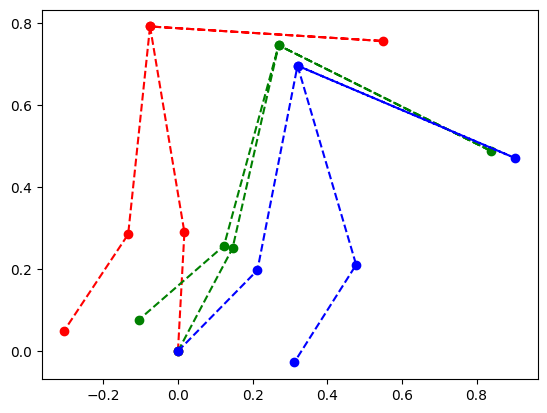

In [66]:
last_X = opti.debug.value(X)
q_sim_ca = last_X[:5, :]
x_1 = sp.zeros(7, N)
y_1 = sp.zeros(7, N)
for i in range(N):
    x_1[:, i], y_1[:, i] = sim_pos_np(q_sim_ca[:, i], opt_ratio)

plt.plot(x_1[:, 0], y_1[:, 0], marker='o', linestyle='--', color='r') 
plt.plot(x_1[:, 10], y_1[:, 10], marker='o', linestyle='--', color='g') 
plt.plot(x_1[:, -1], y_1[:, -1], marker='o', linestyle='--', color='b') 

# Save values in external files
np.save('q_ca_T3.npy', q_sim_ca)
#Np.save('end_time_ca_T3.npy', T)
np.save('body_position_x_T3.npy', x_1)
np.save('body_position_y_T3.npy', y_1)

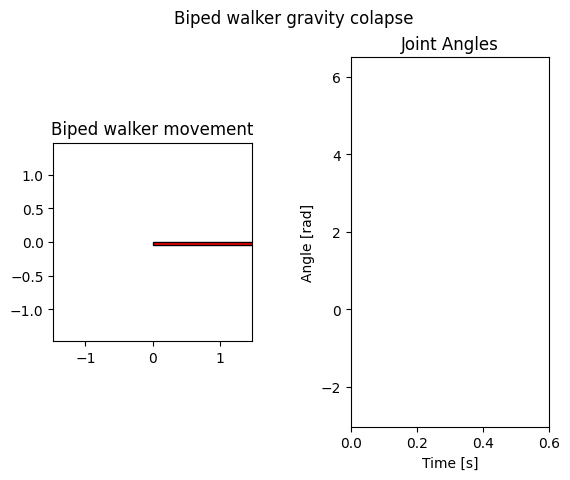

MovieWriter ffmpeg unavailable; using Pillow instead.


In [67]:
# Animate resulting body
q_simulated = np.load('q_ca_T3.npy')
x_simulated = np.load('body_position_x_T3.npy', allow_pickle=True)
y_simulated = np.load('body_position_y_T3.npy', allow_pickle=True)
t_array_acc = np.linspace(0, T, N)
animate_pendulum(t_array_acc, x_simulated, y_simulated, q_simulated)